In [1]:
import sys
sys.path.append('../')
from illustris_frb import exp_simulation, simulation, region
from illustris_frb.utils import isSquare

In [2]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import os
import healpy as hp
import astropy.units as u

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.style.use({
    'font.family':        'serif',
    'font.serif':         ['DejaVu Sans'],
    'mathtext.fontset':   'stixsans',
    'figure.figsize':     (6,4),
    'text.usetex':        False,
    'figure.dpi':         120,
    'savefig.dpi':        250,
    'savefig.bbox':       'tight',
    'savefig.pad_inches': 0.1,
    'axes.prop_cycle':    plt.cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', 
                                               '#d62728', '#9467bd', '#8c564b', 
                                               '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
})

In [4]:
figpath = '/home/submit/aqc/frb_project/figures'
clpath = '/data/submit/submit-illustris/april/data/C_ells'

### Writing my own flat sky cross power estimator

See https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft for how the 2D FFT is done

Let us call the input array $a(\vec{m})$. If it has dimension $(N_0, N_1)$, then $m = (m_0, m_1)$ with $m_0 \in \{0, \ldots, N_0-1\}$ and $m_1 \in \{0, \ldots, N_1-1\}$.

The 2D Fourier transform (as implemented in `numpy`) is defined as 
$$A(\vec{n}) = A_{n_0, n_1} = \sum_{m_0, m_1} a_{m_0, m_1} \exp\left(-2\pi i\left(\frac{n_0}{N_0}m_0 + \frac{n_1}{N_1}m_1\right)\right)$$
with $n_0 \in \{0, \ldots, N_0-1\}$ and $n_1 \in \{0, \ldots, N_1-1\}$.

This is the output of `np.fft.fft2`. At this point it is helpful to shift the $n\text{s}$ such that $n = 0, 1, \ldots, -n/2, \ldots, -1$, so that we can account for the positive and negative frequencies.

After shifting, the corresponding wavenumber to some $n$ is $\frac{2\pi n}{N}$. Because $\vec{\theta} = s\vec{m}$, we scale $n$ by the pixel size $s$ to get $\ell$,
$$\vec{\ell} = \frac{2\pi}{s}\left(\frac{n_0}{N_0},\frac{n_1}{N_1}\right)  $$

Therefore, if we have $\vec{\theta} = s\vec{m}$ (up to a constant), then
$$A(\vec{\ell}) = A(\vec{n}(\vec{\ell})) = \sum_{\vec{\theta}} a(\vec{\theta}) \exp(-i\vec{\ell} \cdot \vec{\theta}) $$

To compute the cross correlation coefficients (see my [notes](https://www.overleaf.com/project/65da4664effb352b8f6f9b13)):
$$C_\ell^{ab} = \frac{s^2}{N_0 N_1}\langle A(\vec{\ell})^* B(\vec{\ell}^\prime) \rangle = \frac{s^2}{N_0 N_1}\frac{1}{\mathrm{\#\, of |\vec{\ell}|=\ell}} \sum_{|\vec{\ell}|=\ell} A(\vec{\ell})^* B(\vec{\ell}) $$

Notes on units: 
- $C_\ell^{Dg}$ will have units of $\mathrm{rad}^2\,\mathrm{pc}\,\mathrm{cm}^{-3}$
- $P_{ge}(k)$ will have units of $\left(\frac{\mathrm{ckpc}}{h}\right)^3$, with $k$ in $\mathrm{ckpc}/h$

In [5]:
def cross_power_estimator_2d(arr_a, arr_b, s, delta_ell, ell_max=None):
    # s: pixel size

    N_0, N_1 = arr_a.shape
    
    f_a = np.fft.fft2(arr_a)
    f_b = np.fft.fft2(arr_b) 
    f_ab = np.real(np.conjugate(f_a)*f_b)
    
    # scale
    vec_ells = np.indices((N_0, N_1), dtype=float)
    for i, N in zip((0,1), (N_0, N_1)): 
        vec_ells[i][ vec_ells[i] >= np.ceil(N/2) ] -= N #effectively, this is fftshift
        vec_ells[i] /= N
    vec_ells = 2*np.pi/s * vec_ells
    ells = norm(vec_ells, axis=0)
    
    if ell_max is None:
        ell_max = np.amax(ells)
    ell_bin_edges = np.arange(0, ell_max, delta_ell)
    counts, _ = np.histogram(ells.flatten(), bins=ell_bin_edges)
    tot, _ = np.histogram(ells.flatten(), bins=ell_bin_edges, weights=f_ab.flatten())

    ell_mids = ell_bin_edges[:-1]+delta_ell/2
    res = (s**2 / (N_0 * N_1)) * tot/counts
    mask = np.nonzero(counts)
    
    return ell_mids[mask], res[mask]

def cross_power_estimator(arr_a, arr_b, s, delta_ell=50):
    # s: pixel size

    if arr_a.shape != arr_b.shape:
        raise Exception('Input arrays must have the same size')
    if not isSquare(arr_a.shape):
        raise Exception('Input arrays must be square')
    
    N = arr_a.shape[0]
    nd = arr_a.ndim
    
    f_a = np.fft.fftn(arr_a)
    f_b = np.fft.fftn(arr_b) 
    f_ab = np.real(np.conjugate(f_a)*f_b)
    
    # scale
    vec_ells = np.indices((N,)*nd, dtype=float)
    vec_ells[ vec_ells >= np.ceil(N/2) ] -= N #effectively, this is fftshift
    vec_ells = 2*np.pi/(N*s) * vec_ells
    ells = norm(vec_ells, axis=0)
    
    ell_bin_edges = np.arange(0, np.amax(ells), delta_ell)
    counts, _ = np.histogram(ells.flatten(), bins=ell_bin_edges)
    tot, _ = np.histogram(ells.flatten(), bins=ell_bin_edges, weights=f_ab.flatten())

    ell_mids = np.convolve(ell_bin_edges, [0.5,0.5], 'valid')
    res = (s/N)**nd * tot/counts
    mask = np.nonzero(counts)
    
    return ell_mids[mask], res[mask]

# cross power estimator from CMB summer school 
# # from https://github.com/jeffmcm1977/CMBAnalysis_SummerSchool/blob/master/CMB_School_Part_04.ipynb
# def calculate_2d_spectrum(Map1,Map2,pix_size, delta_ell,ell_max, N):
#     "calcualtes the power spectrum of a 2d map by FFTing, squaring, and azimuthally averaging"
#     N=int(N)
#     # make a 2d ell coordinate system
#     ones = np.ones(N)
#     inds  = (np.arange(N)+.5 - N/2.) /(N-1) ## why do they divide by N-1??? And this fftshift only works for odd numbers... 
#     kX = np.outer(ones,inds) / (pix_size)
#     kY = np.transpose(kX)
#     K = np.sqrt(kX**2. + kY**2.)
#     ell_scale_factor = 2. * np.pi 
#     ell2d = K * ell_scale_factor
    
#     # make an array to hold the power spectrum results
#     sim.n_bins = int(ell_max/delta_ell)
#     ell_array = np.arange(sim.n_bins)
#     CL_array = np.zeros(sim.n_bins)
    
#     # get the 2d fourier transform of the map
#     FMap1 = np.fft.ifft2(Map1)
#     FMap2 = np.fft.ifft2(Map2)
#     PSMap = np.fft.fftshift(np.real(np.conj(FMap1) * FMap2))
#     # fill out the spectra
#     i = 0
#     while (i < sim.n_bins):
#         ell_array[i] = (i + 0.5) * delta_ell
#         inds_in_bin = ((ell2d >= (i* delta_ell)) * (ell2d < ((i+1)* delta_ell))).nonzero()
#         CL_array[i] = np.mean(PSMap[inds_in_bin])
#         #print i, ell_array[i], inds_in_bin, CL_array[i]
#         i = i + 1
 
#     # return the power spectrum and ell bins
#     return(ell_array,CL_array*np.sqrt(pix_size)*2.) ## why tf is this normalization factor here???

# calculate error bars

def get_Clerr_from_Cls(N_gs, DMs, ells, Clgg, ClDD, res=0.0008, size=0.10, delta_ell=50):
    Omega = size**2
    NlDg2 = (Clgg + 1/(np.sum(N_gs)/Omega))*(ClDD + (np.var(DMs)*res**2))
    return 1 /  np.sqrt(Omega * ells*delta_ell/(2*np.pi) / NlDg2)

def get_Clerr(N_gs, DMs, res=0.0008, size=0.10, delta_ell=50):
    delta_gs = N_gs/np.mean(N_gs) - 1
    ells, Clgg = cross_power_estimator(delta_gs, delta_gs, res, delta_ell=50)
    ells, ClDD = cross_power_estimator(DMs, DMs, res, delta_ell=50)

    return get_Clerr_from_Cls(N_gs, DMs, ells, Clgg, ClDD, res, size, delta_ell)

# plot cross-correlation power spectrum

def plot_xcorr(ells, C_ls, color='b', lw=1, ax=None, label=None, 
               ylim=None, DeltaCs=None, xlabel=r'$\ell$',
               ylabel=r'$C_l^{Dg}$', alpha=1, **kwargs):
    
    # delta_gs = N_gs/np.mean(N_gs) - 1
    # ells, C_ls = cross_power_estimator(DMs, delta_gs, res, delta_ell=delta_ell)

    if ax is None:
        fig, ax = plt.subplots()
    ax.loglog(ells, C_ls, lw=lw, color=color, label=label, **kwargs)
    ax.set_xscale('log')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    ax.set_xlim((ells[0], ells[-1]))
    ax.set_ylim(ylim)

    if DeltaCs is not None:
        ax.fill_between(ells, C_ls-DeltaCs, C_ls+DeltaCs, color=color, alpha=alpha*0.2)

In [6]:
# two methods of fisher matrix

def fisher1(invD, invG, s=1, delta_ell=1):
    N = len(invD)
    A = (N*s)**2
    ell_bin_edges = np.arange(0, np.pi/s, delta_ell)
    ell_bin_midpoints = np.convolve(ell_bin_edges, (0.5, 0.5), mode='valid')
    n_ells = len(ell_bin_midpoints)
    vec_ells = np.indices((N,N), dtype=float)
    vec_ells[ vec_ells >= np.ceil(N/2) ] -= N #effectively, this is fftshift
    vec_ells = 2*np.pi/(N*s) * vec_ells
    ells = norm(vec_ells, axis=0)
    ell_bin_inds = np.digitize(ells, ell_bin_edges) - 1 # which bin each ell corresponds to

    ## compute Fisher matrix
    summand = np.fft.fft2(invD) * np.conjugate(np.fft.fft2(invG)) / (2*A**2) #Eq. 10
    # sum over delta m, delta n
    F = np.empty((n_ells, n_ells))
    ms, ns = np.indices((N,N))
    for i in range(n_ells):
        mask = ell_bin_inds == i
        for j in range(n_ells):
            mask_ = ell_bin_inds == j
            dm = np.subtract(*np.meshgrid(ms[mask], ms[mask_]))
            dn = np.subtract(*np.meshgrid(ns[mask], ns[mask_]))
            F[i,j] = np.sum(np.real(summand[dm,dn]))
    # print(F)
    
    # F = np.zeros((n_ells, n_ells))
    # ells, ell_bin_inds = ells.flatten(), ell_bin_inds.flatten()
    # vec_mns = np.indices((N,N), dtype=float).reshape(2,N**2).T
    # for i, ell in enumerate(ells):
    #     l = ell_bin_inds[i]
    #     if l < n_ells:
    #         for j, ell_ in enumerate(ells):
    #             l_ = ell_bin_inds[j]
    #             if l_ < n_ells:
    #                 dm, dn = np.mod(vec_mns[j] - vec_mns[i], N)
    #                 F[l, l_] += summand[int(dm), int(dn)]
    return F

def fisher2(invD, invG, s=1, delta_ell=1): #brute force
    N = len(invD)
    A = (N*s)**2
    ell_bin_edges = np.arange(0, np.pi/s, delta_ell)
    ell_bin_midpoints = np.convolve(ell_bin_edges, (0.5, 0.5), mode='valid')
    n_ells = len(ell_bin_midpoints)
    vec_ells = np.indices((N,N), dtype=float)
    vec_ells[ vec_ells >= np.ceil(N/2) ] -= N #effectively, this is fftshift
    vec_ells = 2*np.pi/(N*s) * vec_ells
    ells = norm(vec_ells, axis=0)
    ell_bin_inds = np.digitize(ells, ell_bin_edges) - 1

    invD, invG = np.diag(invD.flatten()), np.diag(invG.flatten())

    dC = np.zeros((n_ells, N**2, N**2), dtype=complex)
    x, y = np.indices((N,N))
    dxs = np.subtract(*np.meshgrid(x.flatten(), x.flatten()))
    dys = np.subtract(*np.meshgrid(y.flatten(), y.flatten()))
    vec_mns = np.indices((N,N))
    for i, ell in enumerate(ell_bin_edges[1:]):
        mask = ell_bin_inds == i
        for m, n in vec_mns[:,mask].T:
            dC[i] += np.exp(2j*np.pi/N*(m*dxs+n*dys))
    dC /= A
    F = (1/2) * np.real(np.tensordot(np.matmul(dC, invD), np.matmul(dC, invG), axes=((1,2),(2,1))))
    return F

def fishereye(N, s=1, delta_ell=1): #when invD and invG are diagonal 
    A = (N*s)**2
    ell_bin_edges = np.arange(0, np.pi/s, delta_ell)
    ell_bin_midpoints = np.convolve(ell_bin_edges, (0.5, 0.5), mode='valid')
    n_ells = len(ell_bin_midpoints)
    vec_ells = np.indices((N,N), dtype=float)
    vec_ells[ vec_ells >= np.ceil(N/2) ] -= N #effectively, this is fftshift
    vec_ells = 2*np.pi/(N*s) * vec_ells
    ells = norm(vec_ells, axis=0)
    ell_bin_inds = np.digitize(ells, ell_bin_edges) - 1

    mydiag = np.bincount(ell_bin_inds.flatten(), minlength=n_ells)
    return (1/2) * N**4 / A**2 * np.diag(mydiag[:n_ells])

In [7]:
N = 20
invD, invG = np.ones((N,N)), np.ones((N,N))
print(fisher1(invD, invG))
# print(fisher2(invD, invG))
print(fishereye(N))

[[18.5  0.   0. ]
 [ 0.  46.   0. ]
 [ 0.   0.  82. ]]
[[18.5  0.   0. ]
 [ 0.  46.   0. ]
 [ 0.   0.  82. ]]


In [8]:
# two methods of fisher matrix

def num1(DM, delta_g, frb_mult, s=1, delta_ell=1):
    N = len(DM)
    A = (N*s)**2
    ell_bin_edges = np.arange(0, np.pi/s, delta_ell)
    ell_bin_midpoints = np.convolve(ell_bin_edges, (0.5, 0.5), mode='valid')
    n_ells = len(ell_bin_midpoints)
    vec_ells = np.indices((N,N), dtype=float)
    vec_ells[ vec_ells >= np.ceil(N/2) ] -= N #effectively, this is fftshift
    vec_ells = 2*np.pi/(N*s) * vec_ells
    ells = norm(vec_ells, axis=0)
    ell_bin_inds = np.digitize(ells, ell_bin_edges) - 1 # which bin each ell corresponds to

    invD = frb_mult / np.var(DM)  # flatten and put on diagonal for actual D^{-1}
    invG = np.ones((N,N)) / np.var(delta_g) # shot noise??

    ## compute numerator
    Dd = (DM - np.mean(DM)) * invD
    Gg = delta_g * invG
    num = np.conjugate(np.fft.fft2(Dd)).T * np.fft.fft2(Gg) / A
    num_l, _ = np.histogram(ells.flatten(), bins=ell_bin_edges, weights=num.flatten()) 

    return np.real(num_l)

def num2(DM, delta_g, frb_mult, s=1, delta_ell=1): #brute force
    N = len(DM)
    A = (N*s)**2
    ell_bin_edges = np.arange(0, np.pi/s, delta_ell)
    ell_bin_midpoints = np.convolve(ell_bin_edges, (0.5, 0.5), mode='valid')
    n_ells = len(ell_bin_midpoints)
    vec_ells = np.indices((N,N), dtype=float)
    vec_ells[ vec_ells >= np.ceil(N/2) ] -= N #effectively, this is fftshift
    vec_ells = 2*np.pi/(N*s) * vec_ells
    ells = norm(vec_ells, axis=0)
    ell_bin_inds = np.digitize(ells, ell_bin_edges) - 1

    invD = frb_mult / np.var(DM)  # flatten and put on diagonal for actual D^{-1}
    invG = np.ones((N,N)) / np.var(delta_g) # shot noise??

    ## compute numerator
    Dd = np.atleast_2d(((DM - np.mean(DM)) * invD).flatten())
    Gg = np.atleast_2d((delta_g * invG).flatten()).T

    dC = np.zeros((n_ells, N**2, N**2), dtype=complex)
    x, y = np.indices((N,N))
    dxs = -np.subtract(*np.meshgrid(x.flatten(), x.flatten()))
    dys = -np.subtract(*np.meshgrid(y.flatten(), y.flatten()))
    vec_mns = np.indices((N,N))
    for i in range(n_ells):
        mask = ell_bin_inds == i
        for m, n in vec_mns[:,mask].T:
            dC[i] += np.exp(2j*np.pi/N*(m*dxs+n*dys))
    dC /= A
    num_l = np.matmul(Dd, np.matmul(dC, Gg)).flatten()
    return np.real(num_l)

In [9]:
# cross power spectrum with incomplete data using the optimal quadratic estimator
# see https://www.overleaf.com/read/vdpbdpjvwrmp#2e27ab

def cross_oqe(DM, delta_g, frb_mult, s, delta_ell=50):
    """
    Computes the DM-galaxy cross-correlation using the optimal quadratic
    estimator for an imcomplete DM field. Assumes uncorrelated variance. 

    Parameters
    ----------
        DM : (N,N) arr
            DM field 
        delta_g : (N,N) arr
            Galaxy overdensity field
        frb_mult : (N,N) arr
            Number of FRBs in each pixel
        s : float
            Pixel size in radians
        delta_ell : int
            Power spectrum binsize
    """

    N = len(DM)
    A = (N*s)**2
    ell_bin_edges = np.arange(0, np.pi/s, delta_ell)
    ell_bin_midpoints = np.convolve(ell_bin_edges, (0.5, 0.5), mode='valid')
    n_ells = len(ell_bin_midpoints)
    vec_ells = np.indices((N,N), dtype=float)
    vec_ells[ vec_ells >= np.ceil(N/2) ] -= N #effectively, this is fftshift
    vec_ells = 2*np.pi/(N*s) * vec_ells
    ells = norm(vec_ells, axis=0)
    ell_bin_inds = np.digitize(ells, ell_bin_edges) - 1 # which bin each ell corresponds to

    invD = frb_mult / np.var(DM)  # flatten and put on diagonal for actual D^{-1}
    invG = np.ones((N,N)) / np.var(delta_g) # shot noise??

    ## compute numerator
    Dd = (DM - np.mean(DM)) * invD
    Gg = delta_g * invG
    num = np.conjugate(np.fft.fft2(Dd)) * np.fft.fft2(Gg) / A
    num_l, _ = np.histogram(ells.flatten(), bins=ell_bin_edges, weights=num.flatten()) 

    ## compute Fisher matrix
    summand = np.fft.fft2(invD) * np.conjugate(np.fft.fft2(invG)) / (2*A**2) #Eq. 10
    # sum over delta m, delta n
    F = np.empty((n_ells, n_ells))
    ms, ns = np.indices((N,N))
    for i in range(n_ells):
        mask = ell_bin_inds == i
        for j in range(n_ells):
            mask_ = ell_bin_inds == j
            dm = np.subtract(*np.meshgrid(ms[mask], ms[mask_]))
            dn = np.subtract(*np.meshgrid(ns[mask], ns[mask_]))
            F[i,j] = np.sum(np.real(summand[dm,dn]))
    Finv = np.linalg.inv(F)
    ClDg = np.matmul(Finv, np.atleast_2d(np.real(num_l)).T).flatten() / 2
    return ell_bin_midpoints, ClDg, Finv


"""
def full_oqe(DM, delta_g, s, delta_ell=50):

    # I will use the full optimal quadratic estimator and simultaneously infer
    # the auto and cross power spectrum. The advantage is that I don't have to
    # throw away any pixels from the galaxies.

     # s is pixel size

    N = len(DM)
    A = (N * s)**2
    l_bins = np.arange(0, np.pi/s, delta_ell)
    l_bin_midpoints = np.convolve(l_bins, (0.5, 0.5), mode='valid')
    n_lbins = len(l_bins)-1

    x_d, y_d = np.indices(DM.shape)
    mask = DM != 0
    # remove pixels where there is no FRB (same thing as window function)
    d, x_d, y_d = DM[mask], x_d[mask], y_d[mask]
    d -= np.mean(d)
    n_d = len(d)

    x_g, y_g = np.indices(delta_g.shape)
    g = delta_g.flatten()
    n_g = len(g)

    #all possible pairs of x and y coords
    pxdd, pydd = np.meshgrid(x_d, x_d), np.meshgrid(y_d, y_d) 
    pxgg, pygg = np.meshgrid(x_g, x_g), np.meshgrid(y_g, y_g)
    pxdg, pydg = np.meshgrid(x_d, x_g), np.meshgrid(y_d, y_g)

    D = np.concatenate(d, g)

    # estimate full covariance matrix

    def estimate_C(D1, D2, px, py, nbins=10):
        p1x, p2x = px 
        p1y, p2y = py #all possible pairs of y-distances
        DDT = np.matmul(np.atleast_2d(D1).T, np.atleast_2d(D2)) #n1 x n2
        p_dr = np.sqrt((p1x - p2x)**2 + (p1y - p2y)**2).T # distance between each pair of pixels
        bins = np.linspace(0, np.amax(p_dr), nbins)
        C = np.zeros_like(DDT)
        for i in range(nbins):
            if i==0:
                tmp_mask = (p_dr == bins[i])
            else:
                tmp_mask = (p_dr > bins[i-1]) & (p_dr <= bins[i])
            C[tmp_mask] += np.mean(DDT[tmp_mask])
        return C

    C_est = np.zeros((n_d+n_g,n_d+n_g))
    C_est[:n_d, :n_d] = estimate_C(d, d, pxdd, pxdd)
    C_est[n_d:, n_d:] = estimate_C(g, g, pxgg, pxgg)
    crossC = estimate_C(d, g, pxdg, pxdg) #n_d x n_g
    C_est[:n_d, n_d:] = crossC
    C_est[n_d:, :n_d] = crossC.T

    ## compute block-wise dC (C_{,\lambda})
    # lambdas: [lambda^{DD}, lambda^{Dg}, lambda^{gg}]

    def compute_dC(n1, n2, px, py):
        vec_ells = np.indices((n1, n2)).reshape((2,n1*n2)).T
        ells = norm(vec_ells, axis=1)
        # iterate over lambdas
        dC = np.zeros((n_lbins, n1, n2), dtype='complex128')
        p1x, p2x = px
        p1y, p2y = py
        for i, l in enumerate(l_bins[1:]):
            tmp_mask = (ells > l_bins[0]) & (ells <= l)
            for m, n in vec_ells[tmp_mask]:
                dC[i] += np.exp(2j*np.pi/N*(m*(p2x-p1x)+n*(p2y-p1y)))
        return dC
    
    dC = np.zeros((3*n_lbins, n_d+n_g, n_d+n_g), dtype='complex128')
    dC[:n_lbins, :n_d, :n_d] = compute_dC(n_d, n_d, pxdd, pydd)
    dC[-n_lbins:, -n_g:, -n_g:] = compute_dC(n_g, n_g, pxgg, pygg)
    crossdC = compute_dC(n_d, n_g, pxdg, pydg)
    dC[n_lbins:-n_lbins, :n_d, n_d:] = crossdC
    dC[n_lbins:-n_lbins, n_d:, :n_d] = crossdC.H

    Cinv = np.linalg.inv(C_est)
    CCC = np.matmul(np.matmul(Cinv, dC), Cinv) # stack of matrices of different lambda'

    Finv = np.linalg.inv(np.tensordot(dC, CCC, ((1,2), (2,1)))/2)
    Cls = np.matmul(Finv, np.matmul(np.matmul(d.T, CCC), g))/2

    # compare true C with empirically estimated C
    # C_true = np.tensordot(Cls, dC, 1)

    return l_bin_midpoints, Cls, Finv #, C_true
"""

"\ndef full_oqe(DM, delta_g, s, delta_ell=50):\n\n    # I will use the full optimal quadratic estimator and simultaneously infer\n    # the auto and cross power spectrum. The advantage is that I don't have to\n    # throw away any pixels from the galaxies.\n\n     # s is pixel size\n\n    N = len(DM)\n    A = (N * s)**2\n    l_bins = np.arange(0, np.pi/s, delta_ell)\n    l_bin_midpoints = np.convolve(l_bins, (0.5, 0.5), mode='valid')\n    n_lbins = len(l_bins)-1\n\n    x_d, y_d = np.indices(DM.shape)\n    mask = DM != 0\n    # remove pixels where there is no FRB (same thing as window function)\n    d, x_d, y_d = DM[mask], x_d[mask], y_d[mask]\n    d -= np.mean(d)\n    n_d = len(d)\n\n    x_g, y_g = np.indices(delta_g.shape)\n    g = delta_g.flatten()\n    n_g = len(g)\n\n    #all possible pairs of x and y coords\n    pxdd, pydd = np.meshgrid(x_d, x_d), np.meshgrid(y_d, y_d) \n    pxgg, pygg = np.meshgrid(x_g, x_g), np.meshgrid(y_g, y_g)\n    pxdg, pydg = np.meshgrid(x_d, x_g), np.meshg

In [10]:
# compute P_ge from simulation and ClDg

sim = simulation()

def get_ge_cubes(z):
    snap = sim.closest_snap(sim.comoving_distance(z))
    shape = (sim.n_bins,)*3

    e_cube = np.load(sim.get_emap_path(snap)).reshape(shape)
    e_cube = (e_cube - np.mean(e_cube))/np.mean(e_cube)

    df = pd.read_hdf(sim.get_gmap_path(snap))[['x', 'y', 'z']]
    inds = (np.array(df['x']) // sim.binsize)*sim.n_bins**2 + \
       (np.array(df['y']) // sim.binsize)*sim.n_bins + \
       (np.array(df['z'])  // sim.binsize)

    unique, counts = np.unique(inds, return_counts=True)

    g_cube = np.zeros(sim.n_bins**3)
    g_cube[unique.astype(int)] += counts
    g_cube = g_cube.reshape(shape)
    g_cube = (g_cube - np.mean(g_cube))/np.mean(g_cube)

    return g_cube, e_cube

# ALL DISTANCE UNITS IMPLICITLY HAVE h^{-1} ATTACHED

ne0 = np.mean(np.load(sim.get_emap_path(99))) / (sim.binsize * u.kpc)**3

def get_actual_P_ge(z):
    g_cube, e_cube = get_ge_cubes(z)
    k, Pk = cross_power_estimator(g_cube, e_cube, sim.binsize/1000, delta_ell=0.01) # in Mpc/h
    return k, Pk

def ClDg_to_P_ge(ells, C_ls, z_g, DeltaCs=None):
    x_g = (sim.comoving_distance(z_g) * u.kpc).to(u.Mpc)
    C_ls = (C_ls * u.pc*u.cm**(-3)) * sim.h**(-2)
    k = ells / x_g

    prefactor = x_g**2 / (ne0 * (1+z_g))
    Pk = (prefactor * C_ls).to(u.Mpc**3)

    if DeltaCs is None:
        return k.value, Pk.value
    
    # calculate deltaPs
    DeltaCs = (DeltaCs * u.pc*u.cm**(-3)) * sim.h**(-2)
    dP = (prefactor * DeltaCs).to(u.Mpc**3)
    return k.value, Pk.value, dP.value

## testing putting FRBs in galaxies

In [11]:
origin = 500 * np.array([50, 70, 23])
reg_name = 'A1'
sim = exp_simulation(origin, reg_name=reg_name)

tot_DMs = sim.DM_grid()
gal_DMs = sim.sim_DM_grid(zrange=(0.38, 0.4), N=5000)

ValueError: cannot reshape array of size 1 into shape (5000,)

## how well can we approximate the covariance matrix as diagonal?

In [ ]:
# test on region A1

origin = 500 * np.array([50, 70, 23])
reg_name = 'A1'
sim = exp_simulation(origin, reg_name=reg_name)

N_gs = sim.Ngal_grid()
DMs = sim.DM_grid()

delta_Ds = DMs/np.mean(DMs) - 1 # normalize units
delta_gs = N_gs/np.mean(N_gs) - 1
Delta = np.concatenate((delta_Ds.flatten(), delta_gs.flatten()))

In [ ]:
print(np.mean(delta_Ds * delta_Ds))
print(np.mean(delta_Ds * delta_gs))
print(np.mean(delta_gs * delta_gs))

0.08788380253810268
0.04989711269874072
0.053523726737633615


In [ ]:
def estimate_C(D1, D2, px, py, nbins=10):
    p1x, p2x = px 
    p1y, p2y = py #all possible pairs of y-distances
    DDT = np.matmul(np.atleast_2d(D1).T, np.atleast_2d(D2)) #n1 x n2
    p_dr = np.sqrt((p1x - p2x)**2 + (p1y - p2y)**2).T # distance between each pair of pixels
    bins = np.linspace(0, np.amax(p_dr), nbins)
    # C = np.zeros_like(DDT)
    out = []
    for i in range(nbins):
        if i==0:
            tmp_mask = (p_dr == bins[i])
        else:
            tmp_mask = (p_dr > bins[i-1]) & (p_dr <= bins[i])
        x = np.mean(DDT[tmp_mask])
        out.append(x)
    #     C[tmp_mask] += x
    # return C
    print(out)

In [ ]:
# estimate covariance matrices
x, y= np.indices(delta_Ds.shape)
estimate_C(delta_Ds.flatten(), delta_Ds.flatten(), np.meshgrid(x, x), np.meshgrid(y, y))
estimate_C(delta_Ds.flatten(), delta_gs.flatten(), np.meshgrid(x, x), np.meshgrid(y, y))
estimate_C(delta_gs.flatten(), delta_gs.flatten(), np.meshgrid(x, x), np.meshgrid(y, y))

[0.08788380253810268, 0.006426988772329811, 0.0014769595278523282, 0.0003703495451159193, -0.0008743835445422733, -0.0013933868053950462, -0.0015319945459021087, -0.0027093651508083086, -0.0021048941535415228, -0.004701731116044834]
[0.04989711269874072, 0.0046641724680773185, 0.0010029299299598629, 7.276535448200375e-05, -0.0006140969756158855, -0.0006553283655866774, -0.0010762112724009803, -0.0022853495552222773, -0.0021131121381038807, -0.005824175268034678]
[0.053523726737633615, 0.005988677170517972, 0.0013307896571580948, -0.00026127621030234906, -0.0013434358405138554, -0.0005858928089727124, -0.0007235410492781401, -0.0015833403661823045, -0.0022297928994807824, -0.006513544786915482]


In [ ]:
print('DM covariance diagonal, offdiagonal')
DDT = np.abs(np.matmul(np.atleast_2d(delta_Ds.flatten()).T, np.atleast_2d(delta_Ds.flatten())))
print(np.mean(np.diag(DDT)))
print(np.mean(DDT[ ~np.eye(len(DDT), dtype=bool) ]))

print('\nCross covariance diagonal, offdiagonal')
DgT = np.abs(np.matmul(np.atleast_2d(delta_Ds.flatten()).T, np.atleast_2d(delta_gs.flatten())))
print(np.mean(np.diag(DgT)))
print(np.mean(DgT[ ~np.eye(len(DgT), dtype=bool) ]))

print('\nDM covariance diagonal, offdiagonal')
ggT = np.abs(np.matmul(np.atleast_2d(delta_gs.flatten()).T, np.atleast_2d(delta_gs.flatten())))
print(np.mean(np.diag(ggT)))
print(np.mean(ggT[ ~np.eye(len(ggT), dtype=bool) ]))

DM covariance diagonal, offdiagonal
0.08788380253810268
0.03920172477590505

Cross covariance diagonal, offdiagonal
0.0535679163333541
0.03447448072204598

DM covariance diagonal, offdiagonal
0.053523726737633615
0.030315538384984853


## all regions, 1000 FRBs per square region

### testing OQE with region A1, all FRBs at z=0.4

In [ ]:
origin = 500 * np.array([50, 70, 23])
reg_name = 'A1'
sim = exp_simulation(origin, reg_name=reg_name)

N_gs = sim.Ngal_grid()
DMs = sim.DM_grid()
delta_gs = N_gs/np.mean(N_gs) - 1

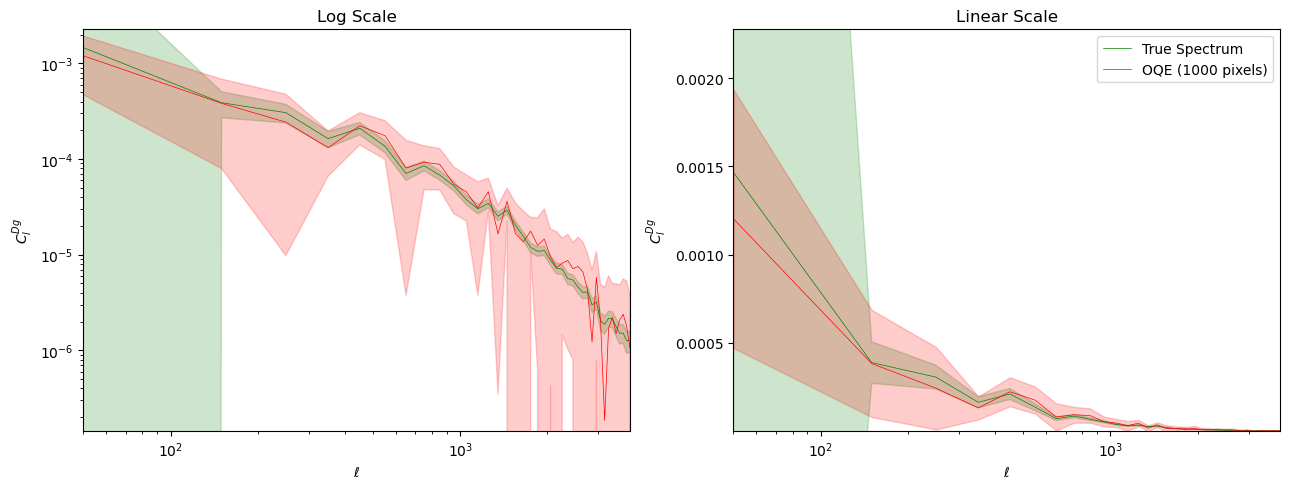

In [ ]:
res, delta_ell, N = .0008, 100, len(DMs)
fig, axes = plt.subplots(1, 2, figsize=(13,5), sharex=True)

# full-grid cross-correlation
ells, ClDg = cross_power_estimator(DMs, delta_gs, res, delta_ell)
_, Clgg = cross_power_estimator(delta_gs, delta_gs, res, delta_ell=delta_ell) # get mean error 
_, ClDD = cross_power_estimator(DMs, DMs, res, delta_ell=delta_ell)
DeltaCs = get_Clerr_from_Cls(DMs, N_gs, ells, Clgg, ClDD, delta_ell=delta_ell)
plot_xcorr(ells, ClDg, ax=axes[0], DeltaCs=DeltaCs, color='g', lw=0.5)
plot_xcorr(ells, ClDg, ax=axes[1], label='True Spectrum', DeltaCs=DeltaCs, color='g', lw=0.5, ylabel=None)

## subset of pixels
n = 1000 # subset of pixels
ntrials = 10 # iterations
oqe_ClDgs = []
for i in range(ntrials):
    DM_subset, frb_mult = np.zeros_like(DMs), np.zeros_like(DMs)
    rand_i, rand_j = np.random.choice(N, size=(2,n))
    DM_subset[rand_i, rand_j] = DMs[rand_i, rand_j]
    np.add.at(frb_mult, (rand_i, rand_j), np.ones_like(DMs)[rand_i, rand_j])
    ells, oqe_ClDg, _ = cross_oqe(DM_subset, delta_gs, frb_mult, s=res, delta_ell=delta_ell)
    oqe_ClDgs.append(oqe_ClDg)
oqe_ClDgs = np.vstack(oqe_ClDgs)
oqe_ClDg = np.mean(oqe_ClDgs, axis=0)
oqe_ClDg_err = np.std(oqe_ClDgs, axis=0)
plot_xcorr(ells, oqe_ClDg, ax=axes[0], DeltaCs=oqe_ClDg_err, color='r', lw=0.5)
plot_xcorr(ells, oqe_ClDg, ax=axes[1], DeltaCs=oqe_ClDg_err, label='OQE (1000 pixels)', color='r', lw=0.5, ylabel=None)

# ## using the OQE with full information
# ells, ClDg, Finv = cross_oqe(DMs, delta_gs, np.ones_like(DMs), s=res, delta_ell=delta_ell)
# DeltaCs = np.sqrt(np.diag(Finv))
# plot_xcorr(ells, ClDg, ax=axes[0], DeltaCs=DeltaCs, color='b', lw=0.5)
# plot_xcorr(ells, ClDg, ax=axes[1], label='OQE (all pixels)', DeltaCs=DeltaCs, color='b', lw=0.5, ylabel=None)

axes[0].set_title('Log Scale')
axes[1].set_title('Linear Scale')
axes[1].set_yscale('linear')
axes[1].legend()

plt.tight_layout()


### let's try putting FRBs in galaxies

## all regions, one FRB per pixel

In [ ]:
origin = 500 * np.array([50, 70, 23])

all_Ngs = []
all_DMs = []

zs = (0.1, 0.2, 0.3)
deltaz = 0.03

for X in ['A', 'B', 'C', 'D', 'E', 'F']:
    for i in range(1,9):
        print(f'{X}{i}')
        sim = exp_simulation(origin, reg_name=f'{X}{i}')

        # get data
        Ngs = [sim.Ngal_grid()]
        for z in zs:
            Ngs.append(sim.Ngal_grid(zrange=(z-deltaz, z+deltaz))) 
        all_Ngs.append(Ngs)
        
        all_DMs.append(sim.DM_grid())

A1
A2
A3
A4
A5
A6
A7
A8
B1
B2
B3
B4
B5
B6
B7
B8
C1
C2
C3
C4
C5
C6
C7
C8
D1
D2
D3
D4
D5
D6
D7
D8
E1
E2
E3
E4
E5
E6
E7
E8
F1
F2
F3
F4
F5
F6
F7
F8


In [ ]:
sns.color_palette('flare')

[(0.9155979, 0.55210684, 0.42070204),
 (0.888292, 0.40830288, 0.36223756),
 (0.81942908, 0.28911553, 0.38102921),
 (0.69226314, 0.23413578, 0.42480327),
 (0.56041794, 0.19845221, 0.44207535),
 (0.42355299, 0.16934709, 0.42581586)]

In [ ]:
# compute c_ells

res, delta_ell = .0008, 50
zs_ = ['0'+str(z).split('.')[-1] for z in zs]
dz_ = '0'+str(deltaz).split('.')[-1]

for i in range(len(zs)+1):

    all_ClDgs, all_Clggs, all_ClDDs = [], [], []

    for N_gss, DMs in zip(all_Ngs, all_DMs):
        N_gs = N_gss[i]
        delta_gs = N_gs/np.mean(N_gs) - 1
        ells, C_ls = cross_power_estimator(DMs, delta_gs, res, delta_ell=delta_ell)

        # for calculating mean err
        _, Clgg = cross_power_estimator(delta_gs, delta_gs, res, delta_ell=delta_ell)
        _, ClDD = cross_power_estimator(DMs, DMs, res, delta_ell=delta_ell)
        all_ClDgs.append(C_ls)
        all_Clggs.append(Clgg)
        all_ClDDs.append(ClDD)

    # get mean error
    mean_Cls = np.mean(np.array(all_ClDgs), axis=0)
    mean_Clggs = np.mean(np.array(all_Clggs), axis=0)
    mean_ClDDs = np.mean(np.array(all_ClDDs), axis=0)
    DeltaCs = get_Clerr_from_Cls(DMs, np.mean(N_gss, axis=0), ells, mean_Clggs, mean_ClDDs, delta_ell=delta_ell)

    # save data
    if i==0:
        suffix = '_allgals'
    else:
        suffix = f'_dz{dz_}_z{zs_[i-1]}' 

    np.save(os.path.join(clpath, f'ells{suffix}.npy'), np.array(ells))
    np.save(os.path.join(clpath, f'all_ClDgs{suffix}.npy'), np.array(all_ClDgs))
    np.save(os.path.join(clpath, f'all_Clggs{suffix}.npy'), np.array(all_Clggs))
    np.save(os.path.join(clpath, f'all_ClDDs{suffix}.npy'), np.array(all_ClDDs))
    np.save(os.path.join(clpath, f'DeltaCs{suffix}.npy'), np.array(DeltaCs))

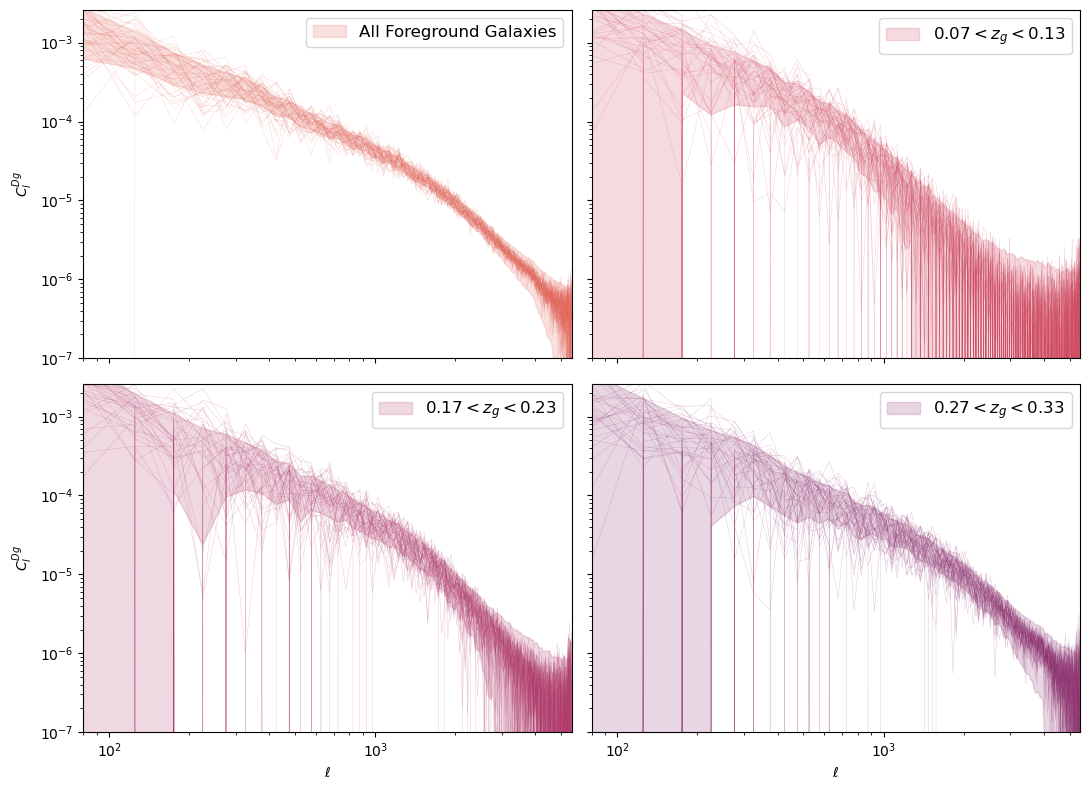

In [ ]:
# logscale

fig, axes_ = plt.subplots(2,2,figsize=(11,8), sharex=True, sharey=True)
axes = axes_.flatten()
colors = sns.color_palette('flare')[1:]

res, delta_ell = .0008, 50
zs_ = [str(z).split('.')[-1] for z in zs]
dz_ = str(deltaz).split('.')[-1]

for i in range(len(zs)+1):
    ax = axes[i]
    xlabel, ylabel = r'$\ell$', r'$C_l^{Dg}$'
    if i%2 == 1:
        ylabel = None
    if i < 2:
        xlabel = None
    if i==0:
        label = 'All Foreground Galaxies'
        suffix = '_allgals'
    else:
        z = zs[i-1]
        label = f'${z-deltaz:.2f} < z_g < {z+deltaz:.2f}$'
        suffix = f'_dz{dz_}_z{zs_[i-1]}'
    
    ells = np.load(os.path.join(clpath, f'ells{suffix}.npy'))
    all_ClDgs = np.load(os.path.join(clpath, f'all_ClDgs{suffix}.npy'))
    DeltaCs = np.load(os.path.join(clpath, f'DeltaCs{suffix}.npy'))

    for j, ClDgs in enumerate(all_ClDgs):
        plot_xcorr(ells, ClDgs, ax=ax, alpha=0.3, color=colors[i], lw=0.3, xlabel=xlabel, ylabel=ylabel)

    # plot mean error
    mean_ClDgs = np.mean(all_ClDgs, axis=0)
    ax.fill_between(ells, mean_ClDgs - DeltaCs, mean_ClDgs + DeltaCs, color=colors[i], alpha=0.2, label = label)

    ax.set_xlim(left=80)
    ax.set_yscale('log')
    ax.set_ylim(bottom=1e-7)
    ax.legend(fontsize=12)

plt.tight_layout()

In [ ]:
# get actual P_ges

P_ges = []
for z_, z in zip(zs_, zs):
    k_ge, Pk = get_actual_P_ge(z)
    np.save(os.path.join(clpath, f'P_ge_z{z_}'), Pk)
    P_ges.append(Pk)
np.save(os.path.join(clpath, f'k_ge'), k_ge)

/tmp/ipykernel_135888/3925709811.py:56: RuntimeWarning: invalid value encountered in divide
  res = (s/N)**nd * tot/counts
/tmp/ipykernel_135888/3925709811.py:56: RuntimeWarning: invalid value encountered in divide
  res = (s/N)**nd * tot/counts
/tmp/ipykernel_135888/3925709811.py:56: RuntimeWarning: invalid value encountered in divide
  res = (s/N)**nd * tot/counts


Text(0, 0.5, '$P_{ge} [(\\mathrm{h}^{-1}\\,\\mathrm{Mpc})^3]$')

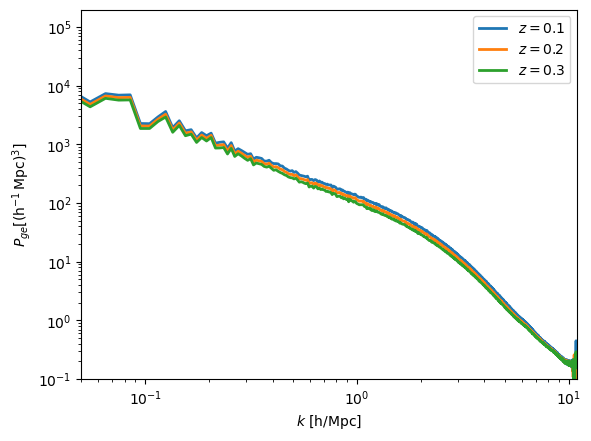

In [ ]:
for z, P_ge in zip(zs, P_ges):
    plt.loglog(k_ge, P_ge, lw=2, label=f'$z={z}$')
plt.legend()
plt.xlim(.05, 11)
plt.ylim(bottom=0.1)
plt.xlabel('$k$ [h/Mpc]')
plt.ylabel(r'$P_{ge} [(\mathrm{h}^{-1}\,\mathrm{Mpc})^3]$')

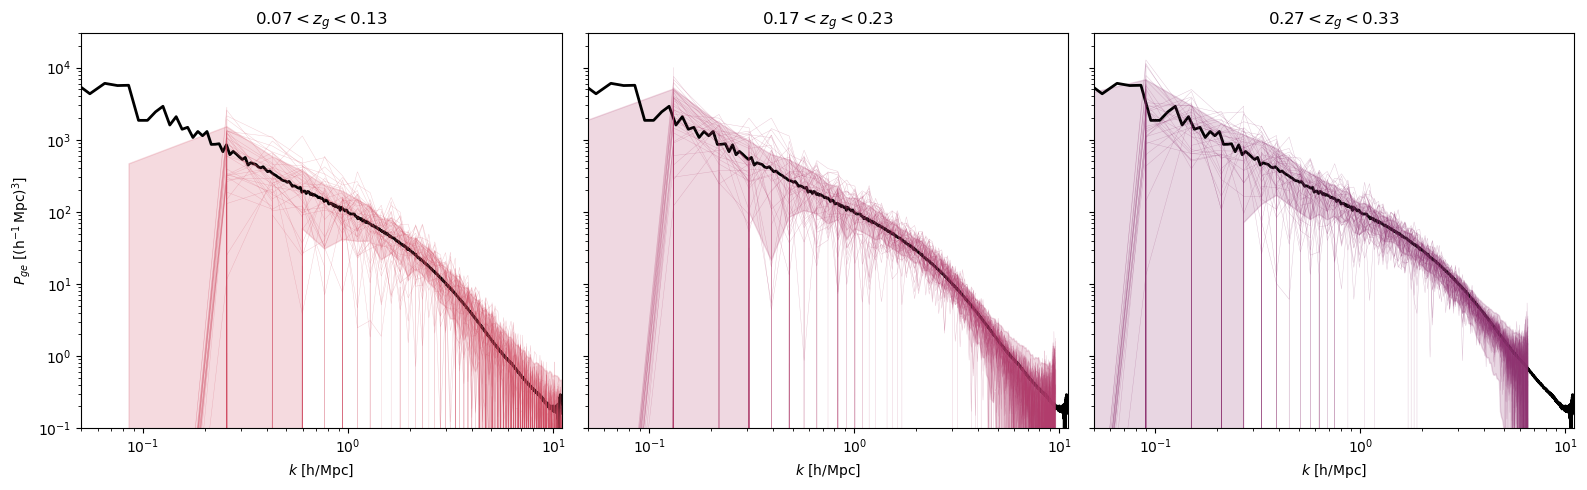

In [ ]:
# logscale

fig, axes_ = plt.subplots(1,3, figsize=(16,5), sharex=True, sharey=True)
axes = axes_.flatten()
colors = sns.color_palette('flare')[2:]
res, delta_ell = .0008, 50
k_ge = np.load(os.path.join(clpath, f'k_ge.npy'))

for i, z in enumerate(zs):
    ax = axes[i]
    color = colors[i]
    xlabel, ylabel = '$k$ [h/Mpc]', None
    if i==0:
        ylabel=r'$P_{ge}~[(\mathrm{h}^{-1}\,\mathrm{Mpc})^3]$'

    ells = np.load(os.path.join(clpath, f'ells_dz{dz_}_z{zs_[i]}.npy'))
    all_ClDgs = np.load(os.path.join(clpath, f'all_ClDgs_dz{dz_}_z{zs_[i]}.npy'))
    DeltaCs = np.load(os.path.join(clpath, f'DeltaCs_dz{dz_}_z{zs_[i]}.npy'))
    P_ge = np.load(os.path.join(clpath, f'P_ge_z{z_}.npy'))
    
    ax.set_title(f'${z-deltaz:.2f} < z_g < {z+deltaz:.2f}$')

    plot_xcorr(k_ge, P_ge, ax=ax, color='k', xlabel=xlabel, ylabel=ylabel, lw=2)
    for j, ClDgs in enumerate(all_ClDgs):
        k, Pk = ClDg_to_P_ge(ells, ClDgs, z)
        ax.loglog(k, Pk, alpha=0.3, color=color, lw=0.3)

    # plot mean error
    mean_ClDgs = np.mean(all_ClDgs, axis=0)
    k, Pk, dP = ClDg_to_P_ge(ells, mean_ClDgs, z, DeltaCs)
    ax.fill_between(k, Pk-dP, Pk+dP, color=color, alpha=0.2)

    ax.set_xlim(.05, 11)
    ax.set_ylim(0.1, 3e4)

plt.tight_layout()

In [ ]:
Clgg.shape

(72,)

In [ ]:
ells.shape

(46,)

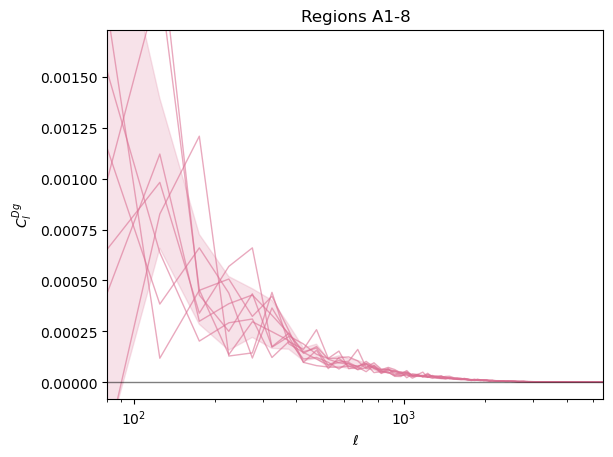

In [ ]:
fig, ax = plt.subplots()
color = 'palevioletred'

all_Cls, all_Clggs, all_ClDDs = [], [], []
for N_gs, DMs in zip(all_Ngs, all_DMs):
    ells, C_ls = plot_xcorr(DMs, N_gs, ax=ax, alpha=0.6, ploterr=False, color=color)

    # for calculating mean err
    delta_gs = N_gs/np.mean(N_gs) - 1
    _, Clgg = cross_power_estimator(delta_gs, delta_gs, s=0.0008, delta_ell=50)
    _, ClDD = cross_power_estimator(DMs, DMs, s=0.0008, delta_ell=50)
    all_Cls.append(C_ls)
    all_Clggs.append(Clgg)
    all_ClDDs.append(ClDD)

# plot mean error
res, size, delta_ell = 0.0008, 0.10, 50
mean_Cls = np.mean(np.array(all_Cls), axis=0)
mean_Clggs = np.mean(np.array(all_Clggs), axis=0)
mean_ClDDs = np.mean(np.array(all_ClDDs), axis=0)
Omega = size**2
NlDg2 = (Clgg + 1/(np.sum(N_gs)/Omega))*(ClDD + (np.var(DMs)*res**2))
DeltaCs = 1 /  np.sqrt(Omega * ells*delta_ell/(2*np.pi) / NlDg2)

plt.fill_between(ells, mean_Cls - DeltaCs, mean_Cls + DeltaCs, color=color, alpha=0.2)

plt.xlim(left=80)
plt.title('Regions A1-8')
plt.axhline(0, color='k', lw=1, alpha=0.5)

## A1, res=0.0008 rad

In [ ]:
origin = 500 * np.array([50, 70, 23])

# reg = region((1.18, -np.pi/2), 1.11, 1.88)
# region_name = 'A1'
# sim = exp_simulation(origin, reg, region_name=region_name)

reg_name = 'A1'
sim = exp_simulation(origin, reg_name=reg_name)

In [ ]:
N_gs = sim.Ngal_grid()
delta_gs = N_gs/np.mean(N_gs) - 1

DMs = sim.DM_grid()

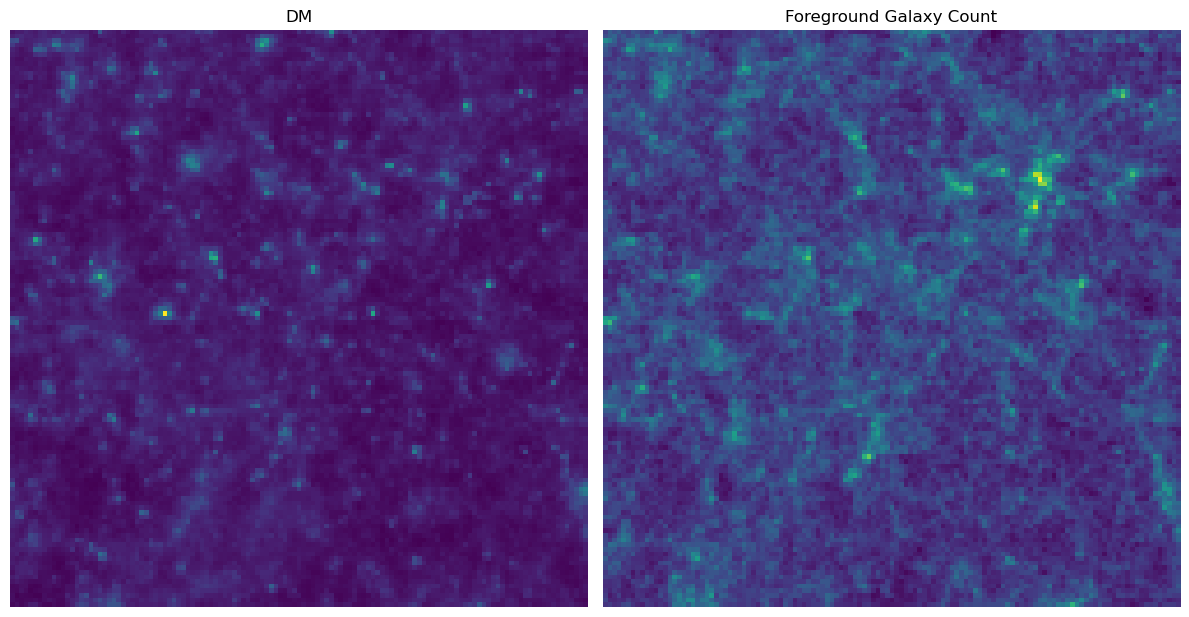

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 20), sharex=True, sharey=True)

axes[0].imshow(DMs)
axes[0].set_title('DM')
axes[0].axis('off')

axes[1].imshow(N_gs)
axes[1].set_title('Foreground Galaxy Count')
axes[1].axis('off')

plt.tight_layout()
# plt.savefig(os.path.join(figpath, 'A1res0008_shell_heatmap.png'), bbox_inches='tight')

Text(0, 0.5, 'Number of foreground galaxies')

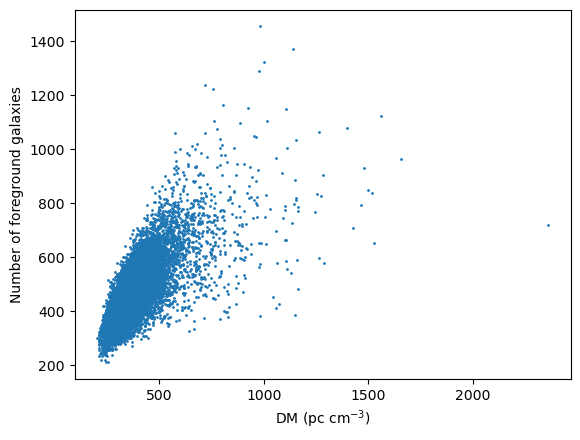

In [ ]:
plt.scatter(DMs.flatten(), N_gs.flatten(), s=1)
plt.xlabel('DM (pc ' + r'cm$^{-3}$)')
plt.ylabel('Number of foreground galaxies')

/tmp/ipykernel_1102505/1790491103.py:25: RuntimeWarning: invalid value encountered in divide
  res = (s**2 / (N_0 * N_1)) * tot/counts


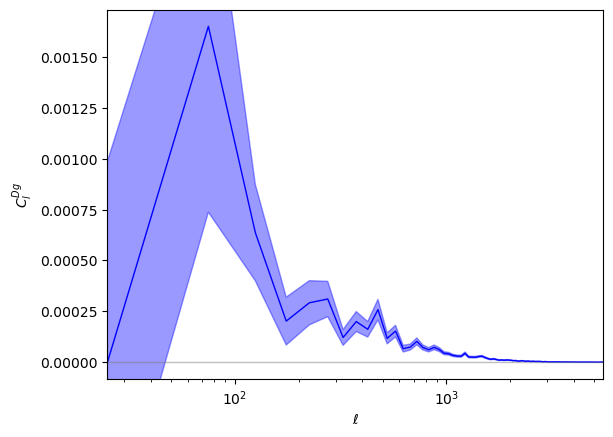

In [ ]:
ells, C_ls, DeltaCs = plot_xcorr(DMs, N_gs)
plt.axhline(0, color='gray', lw=1, alpha=0.5)

/tmp/ipykernel_1102505/1790491103.py:25: RuntimeWarning: invalid value encountered in divide
  res = (s**2 / (N_0 * N_1)) * tot/counts
/work/submit/aqc/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/work/submit/aqc/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


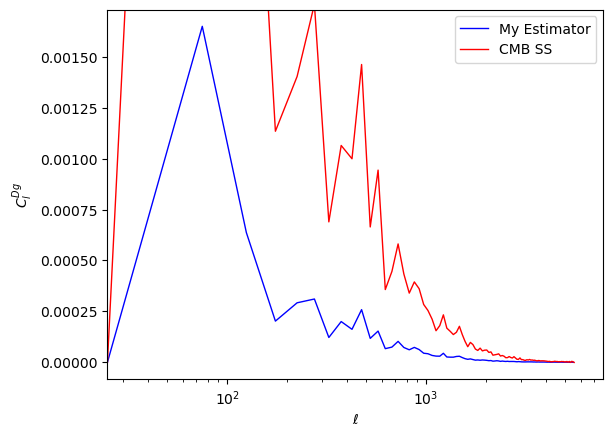

In [ ]:
# both estimators
fig, ax = plt.subplots()
_ = plot_xcorr(DMs, N_gs, reg, ax=ax, label='My Estimator', ploterr=False)
_ = plot_xcorr(DMs, N_gs, reg, ax=ax, estimator=calculate_2d_spectrum, label='CMB SS', color='r', ploterr=False)
plt.legend()

/tmp/ipykernel_1102505/1790491103.py:25: RuntimeWarning: invalid value encountered in divide
  res = (s**2 / (N_0 * N_1)) * tot/counts


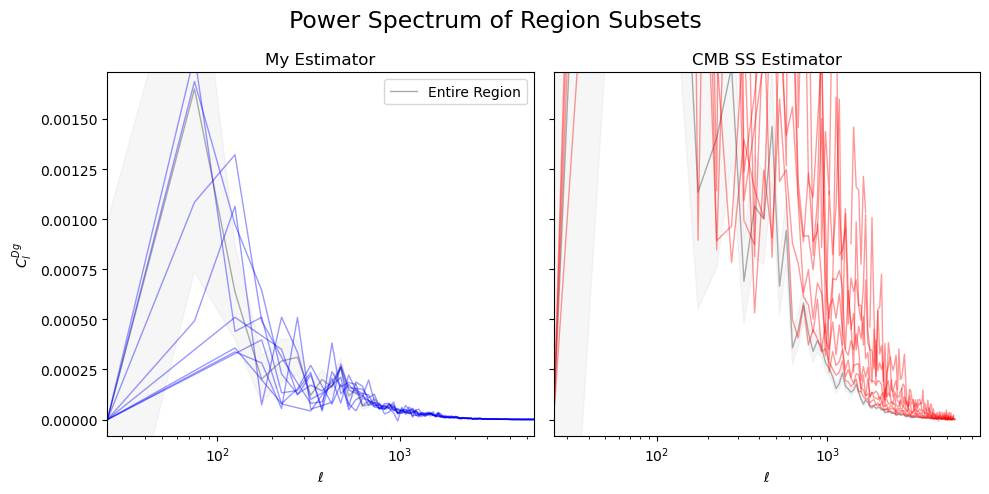

In [ ]:
# test if the normalization stays constant with subsets of the region

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10,5))
_ = plot_xcorr(DMs, N_gs, reg=reg, ax=axes[0], color='darkgray', label='Entire Region')
_ = plot_xcorr(DMs, N_gs, reg=reg, ax=axes[1], estimator=calculate_2d_spectrum, color='darkgray')

for i in range(5, 45, 5):
    _ = plot_xcorr(DMs[i:-i, i:-i], N_gs[i:-i, i:-i], reg=reg, ax=axes[0], ploterr=False, alpha=0.4)
    _ = plot_xcorr(DMs[i:-i, i:-i], N_gs[i:-i, i:-i], reg=reg, ax=axes[1], 
                   estimator=calculate_2d_spectrum, ploterr=False, color='r', alpha=0.4)
    
axes[0].set_title('My Estimator')
axes[1].set_title('CMB SS Estimator')
axes[1].set_ylabel('')
plt.suptitle('Power Spectrum of Region Subsets', fontsize=17)

axes[0].legend()
plt.tight_layout()

# i = 30
# nside = reg.nside - i

# for m,n in np.indices((i,i)).reshape(i**2, 2):
#     _ = plot_xcorr(DMs[m:m+nside, n:n+nside], N_gs[m:m+nside, n:n+nside], reg=reg, ax=ax, ploterr=False, alpha=0.01)

### look at different slices of redshift

## cross correlation estimator experiment

In [ ]:
gcoords = np.array(pd.read_hdf('/data/submit/submit-illustris/april/data/g_maps/99_galaxies.hdf5')[['x', 'y', 'z']])
gcoords -= sim.boxsize/2 * np.ones(3)

gcoords = gcoords[ norm(gcoords, axis=1) < 85890.22430758 ] #edge of snapshot 97

In [ ]:
nside = 1024 #resolution 0.0001 rad
npix = hp.nside2npix(nside)

ipix = hp.vec2pix(nside, gcoords[:,0], gcoords[:,1], gcoords[:,2])

pix_arr = np.zeros(npix)
pix_arr[ipix] = 1
pix_arr = (pix_arr - np.mean(pix_arr))/np.mean(pix_arr)

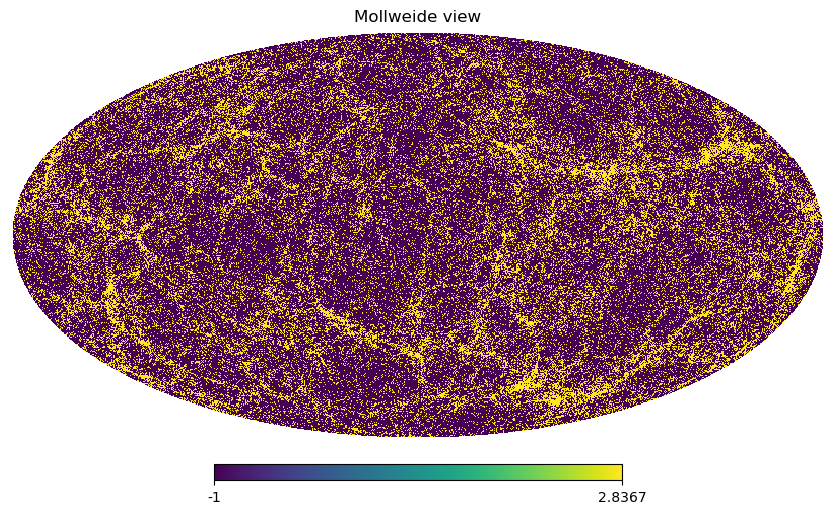

In [ ]:
hp.mollview(pix_arr)

In [ ]:
C_l_sph = hp.alm2cl(hp.map2alm(pix_arr))
ls = np.arange(len(C_l_sph))

(90, 3000)

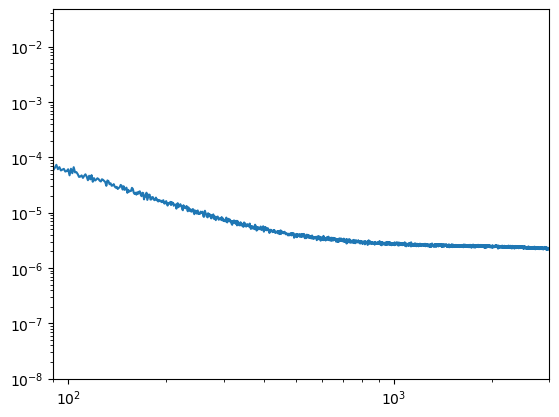

In [ ]:
plt.loglog(ls[1:], C_l_sph[1:])
plt.ylim(bottom=1e-8)
plt.xlim(left=90, right=3000)

In [ ]:
# from region flatsky

reg = region((0, 0), 0, 0.1, size=0.18, res=0.001)
region_name = 'confirm_test'

sim = exp_simulation(500 * np.array([50, 70, 23]), reg, region_name=region_name)

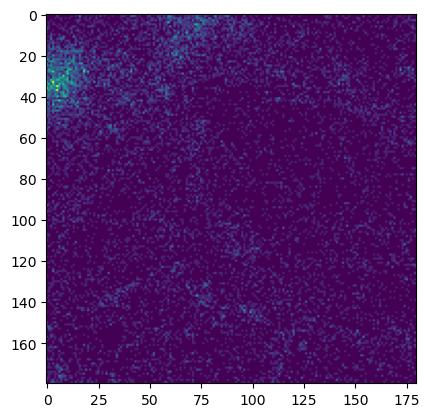

In [ ]:
snaps = (99, 98, 97)
N_gs = sim.Ngal_grid(snaps)
delta_gs = N_gs/np.mean(N_gs) - 1

plt.imshow(N_gs)

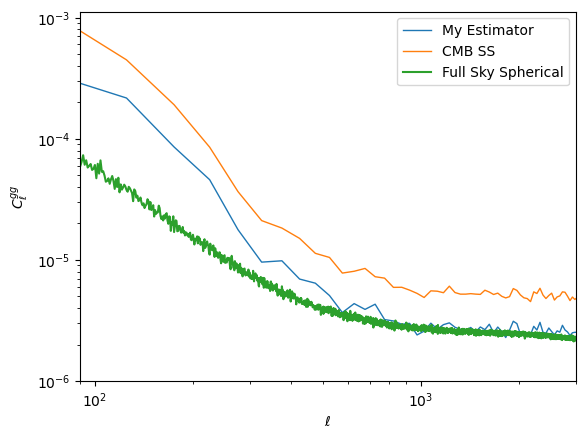

In [ ]:
ells_g, C_ls_g = cross_power_estimator(delta_gs, delta_gs, sim.region.res, delta_ell=50)
ells_g_, C_ls_g_ = calculate_2d_spectrum(delta_gs, delta_gs, sim.region.res, 50, 4000, sim.region.nside)
fig, ax = plt.subplots()
plot_xcorr(ells_g, C_ls_g, ax, label='My Estimator')
plot_xcorr(ells_g_, C_ls_g_, ax, label='CMB SS')

ax.loglog(ls[1:], C_l_sph[1:], label='Full Sky Spherical')
ax.set_ylim(bottom=1e-6)
ax.set_xlim(left=90, right=3000)

ax.set_ylabel(r'$C_\ell^{gg}$')
plt.legend()

In [ ]:
df = pd.read_hdf(sim.get_shell_path(99))
df

,x,y,z,theta_,phi_


In [ ]:
sim.boxsize/2

In [ ]:
all_snaps = np.arange(99, 71, -1)
N_gs = sim.Ngal_grid(all_snaps)
delta_gs = N_gs/np.mean(N_gs) - 1

DMs = sim.DM_grid()

## flat sky res001 with new code

In [ ]:
all_snaps = np.arange(99, 71, -1)
origin = 500 * np.array([50, 70, 23])
reg = region((0, 0), 0, 0.1, size=0.18, res=0.001)
region_name = 'confirm_test'
suffix = '_res001'
sim = exp_simulation(origin, reg, region_name=region_name, suffix=suffix)

N_gs = sim.Ngal_grid(all_snaps)
delta_gs = N_gs/np.mean(N_gs) - 1

DMs = sim.DM_grid()

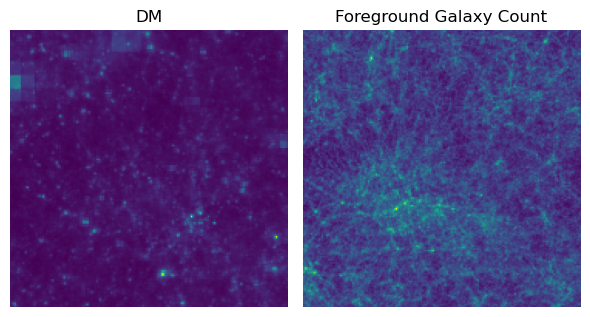

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 10), sharex=True, sharey=True)

axes[0].imshow(DMs)
axes[0].set_title('DM')
axes[0].axis('off')

axes[1].imshow(N_gs)
axes[1].set_title('Foreground Galaxy Count')
axes[1].axis('off')

plt.tight_layout()

(0.0, 2400.25)

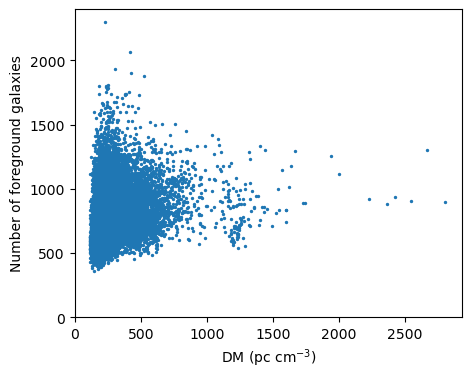

In [ ]:
fig, ax = plt.subplots(figsize=(5,4))

ax.scatter(DMs.flatten(), N_gs.flatten(), s=2)
ax.set_xlabel(r'DM (pc cm$^{-3}$)')
ax.set_ylabel('Number of foreground galaxies')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

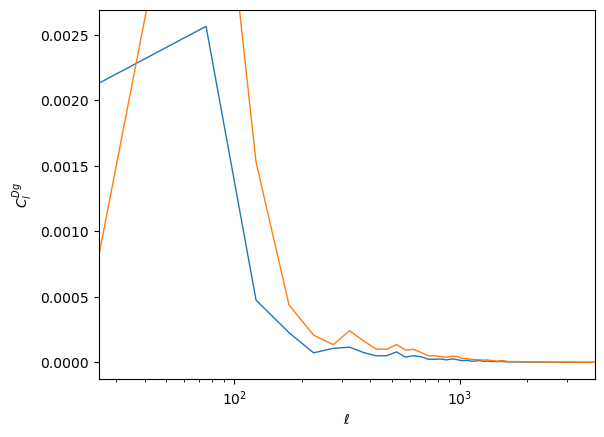

In [ ]:
#my cross power estimator

ells, C_ls = cross_power_estimator(DMs, delta_gs, sim.region.res, delta_ell=50)
ells_, C_ls_ = calculate_2d_spectrum(DMs, delta_gs, sim.region.res, 50, 4000, sim.region.nside)

fig, ax = plt.subplots()
plot_xcorr(ells, C_ls, ax)
plot_xcorr(ells_, C_ls_, ax)

## Flat sky res=0.001 rad, galaxy shell at z=0.2

In [ ]:
df = pd.read_hdf(os.path.join(datapath, 'test_flat_res001_shell.hdf5'))
df

,DM,N_g
0,543.007911,77
1,392.020168,55
2,377.327152,56
3,325.322239,41
4,335.768318,24
...,...,...
32395,311.358084,75
32396,309.400499,108
32397,576.706769,94
32398,520.455418,85


In [ ]:
shape = np.array((180,180))

DMs = np.array(df['DM']).reshape(shape)
N_gs = (np.array(df['N_g']).reshape(shape) / df['N_g'].mean()) - 1

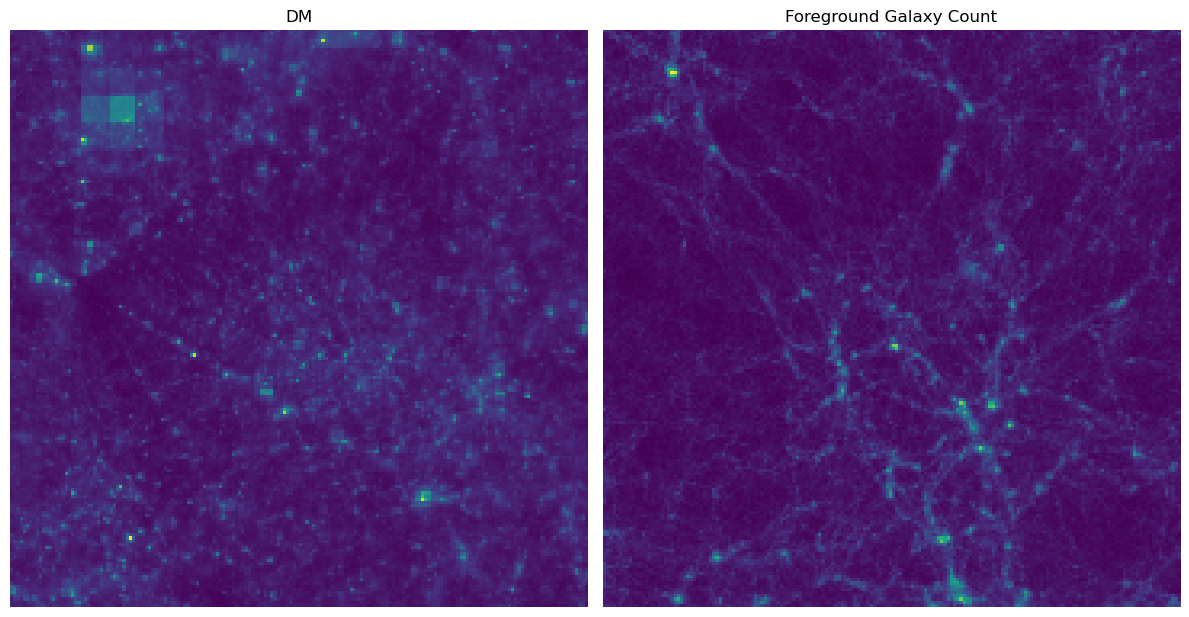

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 20), sharex=True, sharey=True)

axes[0].imshow(DMs)
axes[0].set_title('DM')
axes[0].axis('off')

axes[1].imshow(N_gs)
axes[1].set_title('Foreground Galaxy Count')
axes[1].axis('off')

plt.tight_layout()
# plt.savefig(os.path.join(figpath, 'test_flat_res001_shell_heatmap.png'), bbox_inches='tight')

## Flat Sky: res=0.001 rad

In [ ]:
dfpath = os.path.join(datapath,'test_flat_res001.hdf5')
df = pd.read_hdf(dfpath)

### examine data

In [ ]:
df

,DM,N_g
0,543.007911,807
1,392.020168,884
2,377.327152,812
3,325.322239,1128
4,335.768318,824
...,...,...
32395,311.358084,783
32396,309.400499,816
32397,576.706769,702
32398,520.455418,675


In [ ]:
shape = np.array((180,180))

DMs = np.array(df['DM']).reshape(shape)
N_gs = (np.array(df['N_g']).reshape(shape) / df['N_g'].mean()) - 1

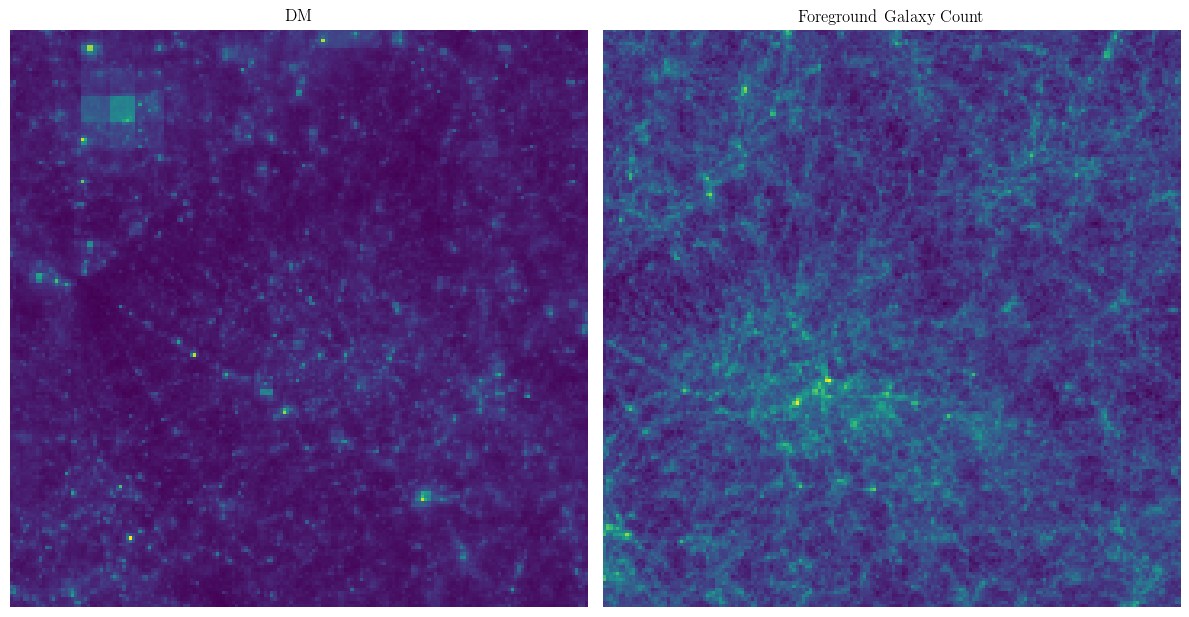

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 20), sharex=True, sharey=True)

axes[0].imshow(DMs)
axes[0].set_title('DM')
axes[0].axis('off')

axes[1].imshow(N_gs)
axes[1].set_title('Foreground Galaxy Count')
axes[1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(figpath, 'test_flat_res001_heatmap.png'), bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df['DM'], df['N_g'], s=2)
ax.set_xlabel(r'DM (pc cm$^{-3}$)')
ax.set_ylabel('Number of foreground galaxies')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

# plt.savefig(os.path.join(figpath, 'test_flat_res001_scatter.png')) 

### power spectrum

In [ ]:
#my cross power estimator

ells, C_ls = cross_power_estimator(DMs, N_gs, 0.001, delta_ell=50)

(-0.15, 0.25)

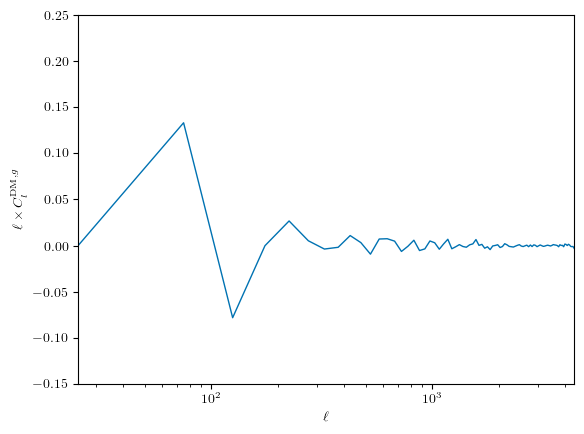

In [ ]:
plt.plot(ells, ells*C_ls, lw=1)
plt.xscale('log')
plt.ylabel(r'$\ell \times C_l^{\mathrm{DM}, g}$')
plt.xlabel(r'$\ell$')

plt.xlim((ells[0], ells[-1]))
plt.ylim((-0.15, 0.25))

In [ ]:
#summer school cross power estimator

ells_, C_ls_ = calculate_2d_spectrum(DMs, N_gs, 0.001, 50, 4416, 180)

(-0.15, 0.25)

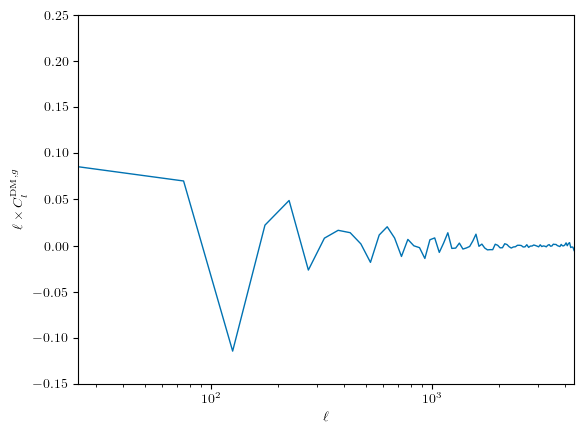

In [ ]:
plt.plot(ells_, ells_*C_ls_, lw=1)
plt.xscale('log')
plt.ylabel(r'$\ell \times C_l^{\mathrm{DM}, g}$')
plt.xlabel(r'$\ell$')

plt.xlim((ells[0], ells[-1]))
plt.ylim((-0.15, 0.25))

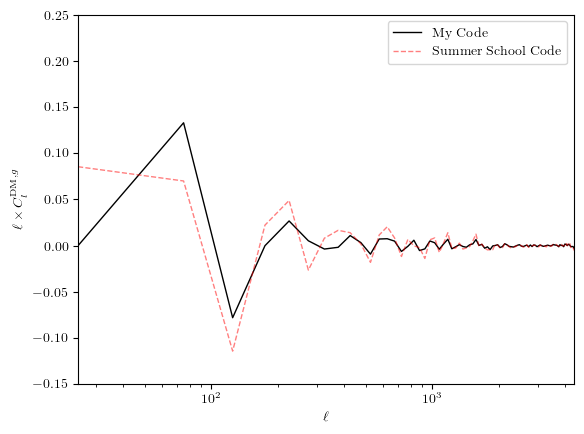

In [ ]:
#let's overlay them
plt.plot(ells, ells*C_ls, lw=1, color='k', label='My Code')
plt.plot(ells_, ells_*C_ls_, lw=1, color='r', alpha=0.5, linestyle='--', label='Summer School Code')

plt.xscale('log')
plt.ylabel(r'$\ell \times C_l^{\mathrm{DM}, g}$')
plt.xlabel(r'$\ell$')

plt.xlim((ells[0], ells[-1]))
plt.ylim((-0.15, 0.25))

plt.legend()
# plt.savefig(os.path.join(figpath, 'test_flat_res001_PS_compare.png'), bbox_inches='tight')

Text(0.5, 1.0, 'Galaxy Overdensity Power Spectrum')

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream V

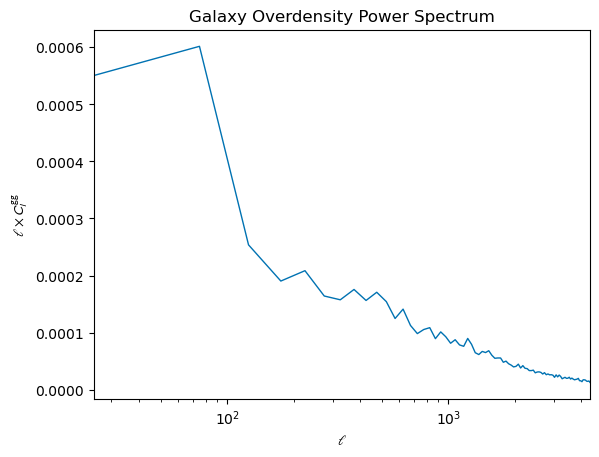

In [ ]:
ells_gg, C_ls_gg = cross_power_estimator(N_gs, N_gs, 0.001, delta_ell=50) #autocorrelation
plt.plot(ells_gg, ells_gg*C_ls_gg, lw=1)
plt.xscale('log')
plt.ylabel(r'$\ell \times C_l^{\mathrm{gg}}$')
plt.xlabel(r'$\ell$')

plt.xlim((ells_gg[0], ells_gg[-1]))
plt.title('Galaxy Overdensity Power Spectrum')

## Flat Sky: res=0.01 rad

In [ ]:
datapath = '/home/tnguser/frb_project/data/test_flat_res01.hdf5'
df = pd.read_hdf(datapath)

(0.0, 133095.2)

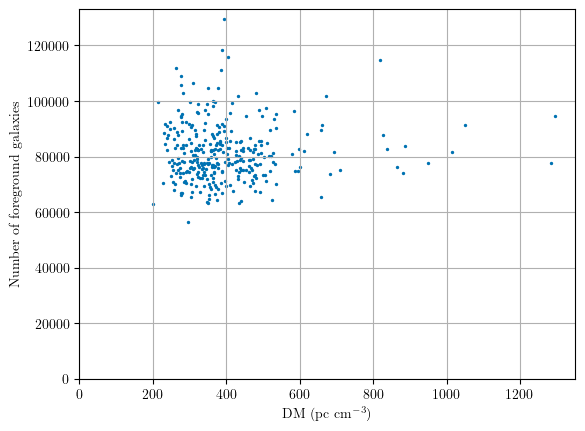

In [ ]:
plt.scatter(df['DM'], df['N_g'], s=2)
plt.xlabel(r'DM (pc cm$^{-3}$)')
plt.ylabel('Number of foreground galaxies')
plt.xlim(left=0)
plt.ylim(bottom=0)

In [ ]:
shape = np.array((18,18))

DMs = np.array(df['DM']).reshape(shape)
N_gs = (np.array(df['N_g']).reshape(shape) / df['N_g'].mean()) - 1 #galaxy overdensity field
ells, C_ls = cross_power_estimator(DMs, N_gs, 0.01)

Text(0.5, 0, '$\\ell$')

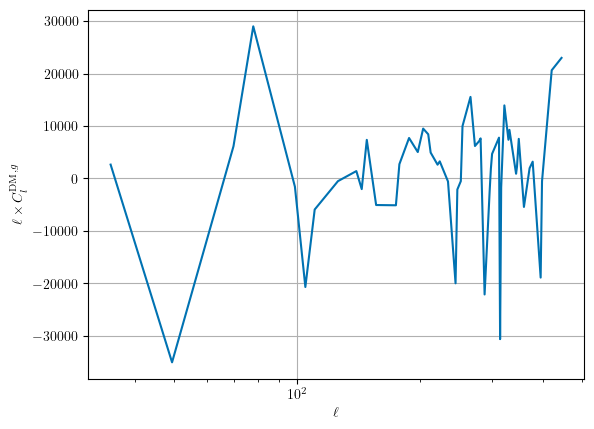

In [ ]:
plt.plot(ells, ells*np.real(C_ls))
plt.xscale('log')
plt.ylabel(r'$\ell \times C_l^{\mathrm{DM}, g}$')
plt.xlabel(r'$\ell$')

In [ ]:
shape = np.array((18,18))

DMs = np.array(df['DM']).reshape(shape)
N_gs = (np.array(df['N_g']).reshape(shape) / df['N_g'].mean()) - 1 #galaxy overdensity field
ells, C_ls = calculate_2d_spectrum(DMs, N_gs, 40, 400, 0.01, shape[0])

Text(0.5, 0, '$\\ell$')

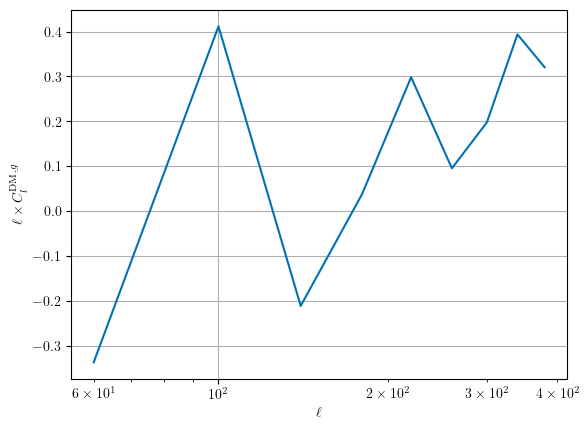

In [ ]:
plt.plot(ells[1:], (ells*np.real(C_ls))[1:])
plt.xscale('log')
plt.ylabel(r'$\ell \times C_l^{\mathrm{DM}, g}$')
plt.xlabel(r'$\ell$')

## Full spherical harmonic transform with healpy: nside=64

In [ ]:
nside=128
datapath = f'/home/tnguser/frb_project/data/test_nside{nside}.hdf5'

In [ ]:
df = pd.read_hdf(datapath)
df

,DM,N_g
90370,422.465899,52473
90371,452.089202,53200
90372,410.856370,43449
90373,417.519176,53042
90374,337.060859,55115
...,...,...
105738,321.664284,43643
105739,571.127321,44142
105740,325.106797,40938
105741,304.781413,52278


In [ ]:
def hp_cross_power_estimator(arr_a, arr_b, pixels, nside):
    s2 = hp.nside2pixarea(nside)
    fsky = s2*len(pixels)/(4*np.pi)
    N = hp.nside2npix(nside)
    
    a = np.zeros(N)
    a[pixels] = arr_a/s2
    
    b = np.zeros(N)
    b[pixels] = arr_b/s2
    
    alm_a = hp.sphtfunc.map2alm(a)
    alm_b = hp.sphtfunc.map2alm(b)
    
    return hp.sphtfunc.alm2cl(alm_a, alm_b) / fsky

In [ ]:
delta_g = df['N_g']/df['N_g'].mean() - 1
C_ls = hp_cross_power_estimator(df['DM'], delta_g, df.index, nside)

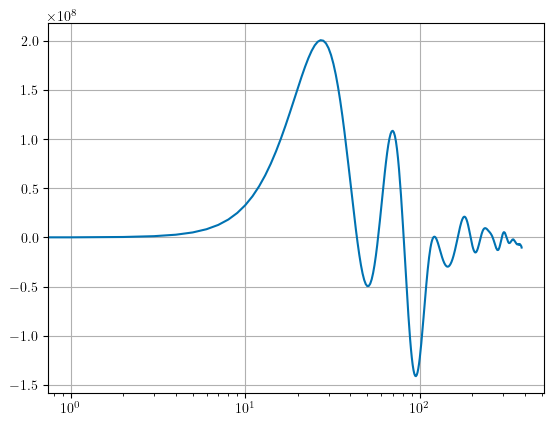

In [ ]:
ls = np.arange(len(C_ls))
plt.plot(ls, ls*C_ls)
plt.xscale('log')